In [1]:
import torch
import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms
import pickle as pkl
import torch
# import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def pred_MBRNN(inter_arrival_moms, service_time_moms, initial_prob, sueqence_len):
    input_single_time_period = torch.cat((torch.log(service_time_moms), torch.log(inter_arrival_moms), initial_prob))
    input_ = input_single_time_period.tile((sueqence_len,)).reshape(sueqence_len, input_single_time_period.shape[0]  )
    input_ = input_.float()

    m = nn.Softmax(dim=2)
    input_ = input_.reshape(-1, sueqence_len, input_size)#.to(device) 

    # Forward pass
    outputs = model(input_)
    soft = m(outputs)
    
    return soft

In [3]:
sueqence_len = 180

class my_Dataset(Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, data_paths):
        self.data_paths = data_paths

    def __len__(self):
        return len(self.data_paths)

    
    def __getitem__(self, index):

        x, y = pkl.load(open(self.data_paths[index], 'rb'))

        inputs = torch.from_numpy(x[:, :sueqence_len, :21 + 30])
        x = torch.cat((inputs[:, :, :num_moms], inputs[:, :, 10:10 + num_moms], inputs[:, :, 21:]), 2)
        y = torch.from_numpy(y[:, :, :])

        return (x, y)

In [4]:
output_size = 51
num_moms = 4
input_size = 30+2*num_moms

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)#.to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)#.to(device)
        out, _ = self.lstm(x.float(), (h0.float(), c0.float()))

        
        out = self.fc(out)
        
        return out
   

In [5]:
hidden_size = 128
num_layers = 4
output_size = 51


model = RNN(input_size, hidden_size, num_layers, output_size)  # .to(device)

if not torch.cuda.is_available():

    model.load_state_dict(torch.load('MBRNN2.pkl', map_location=torch.device('cpu')))

else:
    model.load_state_dict(torch.load('MBRNN2.pkl'))


In [6]:
batch_size = 1

test1_path_files =  '.\long_sim_180_fix'  

file_list = os.listdir(test1_path_files)

data_paths = [os.path.join(test1_path_files, name) for name in file_list]

dataset = my_Dataset(data_paths)

test_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

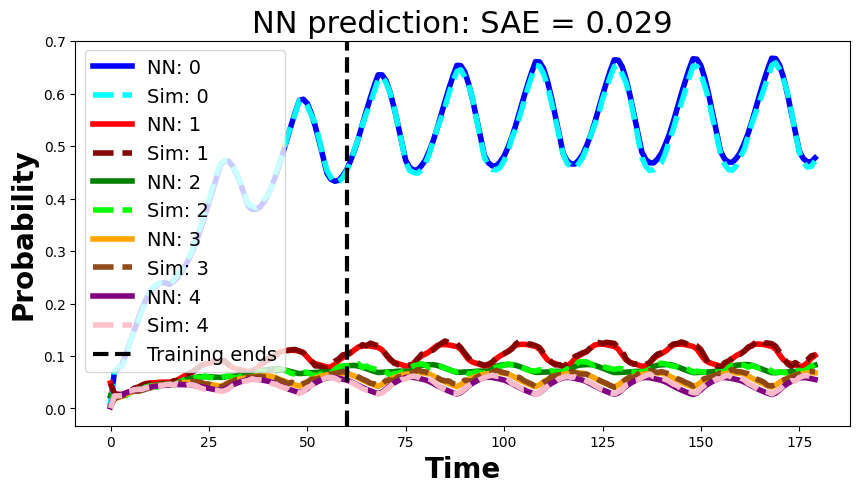

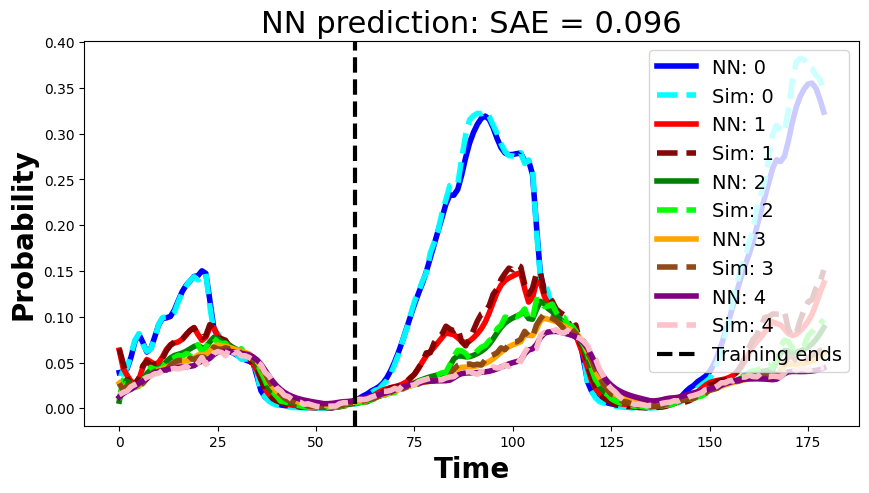

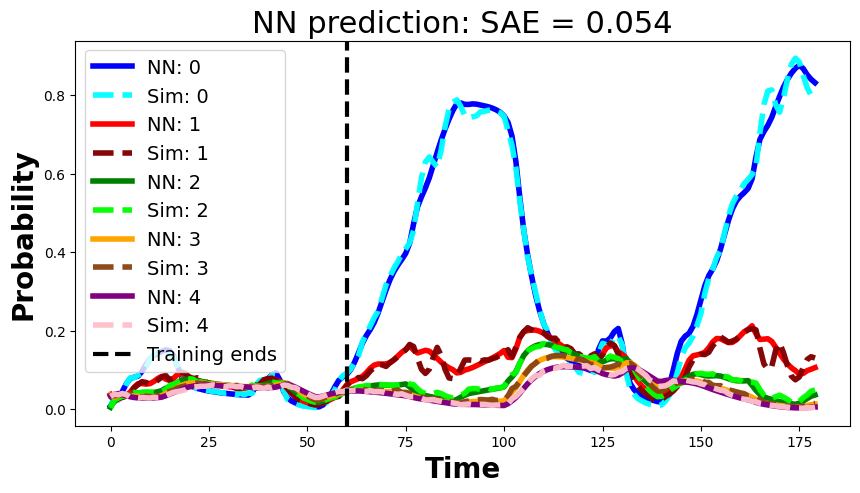

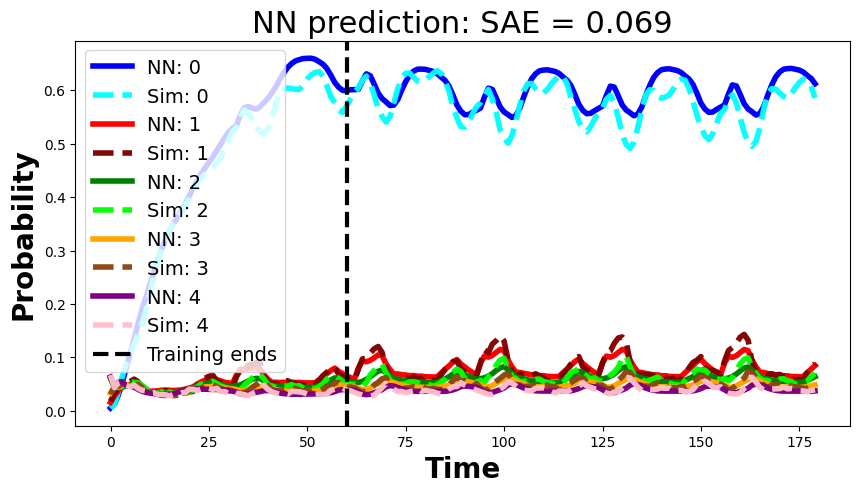

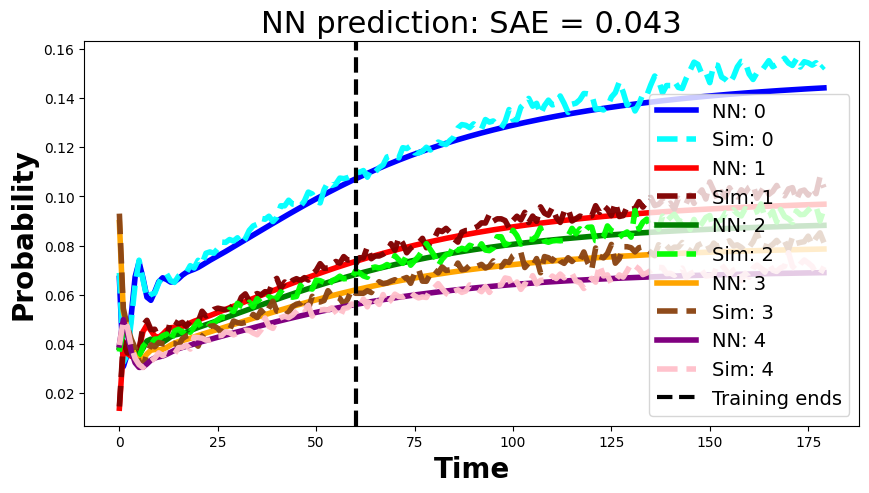

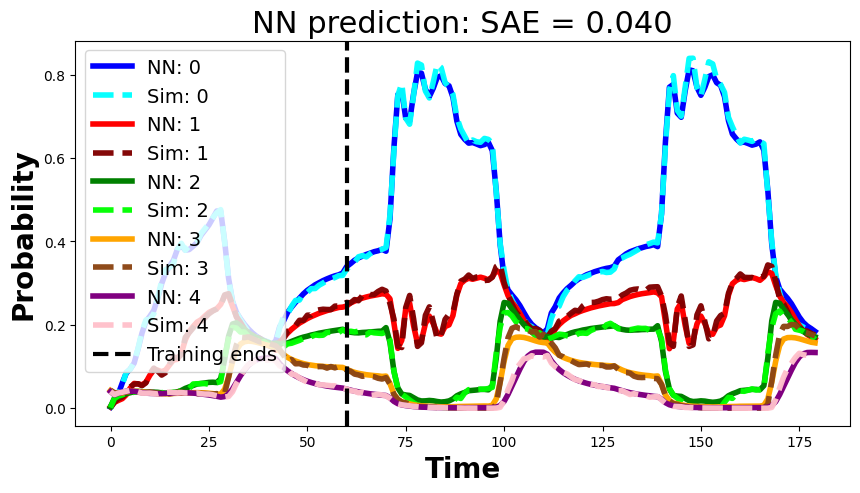

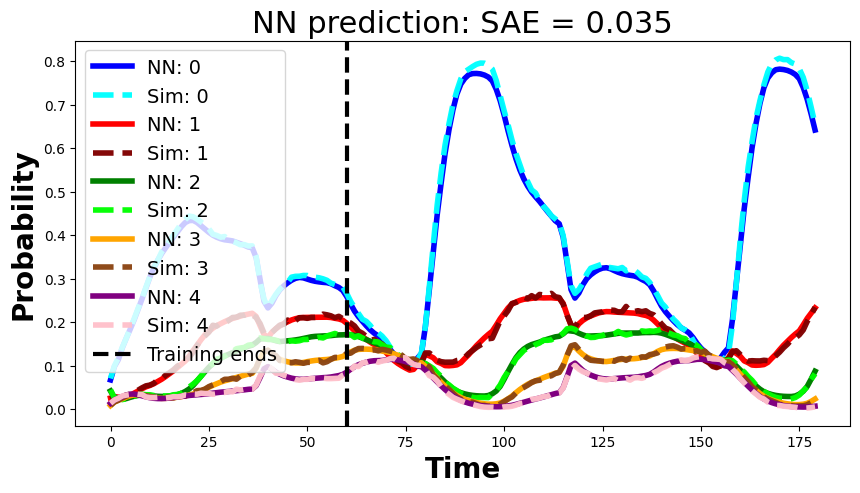

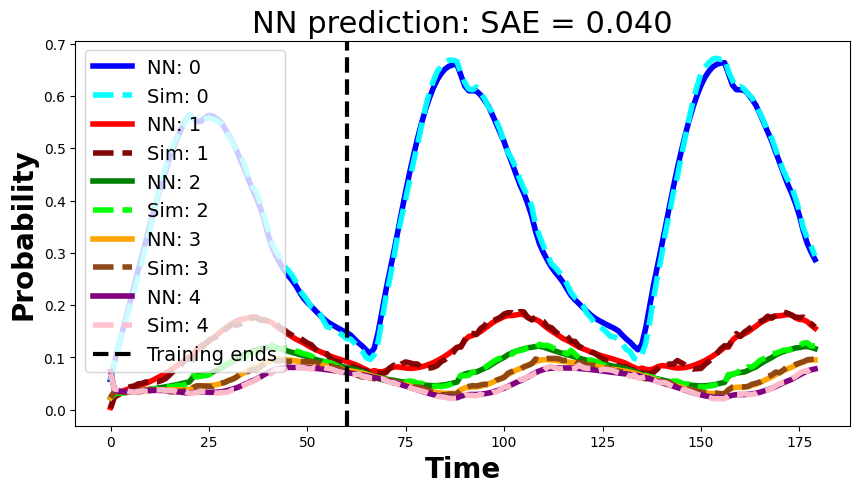

In [7]:
sequence_length = 180
cols = []
for time in range(180):
    cols.append('Time_' + str(time))
    

df_list = []

for i, (inputs, labels) in enumerate(test_loader):
    
    if i > 1:
        break
    else:
    
        inputs = inputs.reshape(inputs.shape[0]*inputs.shape[1],inputs.shape[2],inputs.shape[3])
        labels = labels.reshape(labels.shape[0]*labels.shape[1],labels.shape[2],labels.shape[3])

        inputs = inputs.float()
        labels = labels.float()

        m = nn.Softmax(dim=2)
        inputs = inputs.reshape(-1, sequence_length, input_size)#.to(device) 


        # Forward pass
        outputs = model(inputs)
        soft = m(outputs)

        for ind_0 in range(1,5):
            with torch.no_grad():
                plt.figure(figsize = (10,5))


                SAE = np.abs(soft.detach().numpy()[ind_0:ind_0+1,:,:] -labels.numpy()[ind_0:ind_0+1,:,:]).sum(axis = 2).mean()

                plt.plot(torch.arange(sueqence_len), soft[ind_0,:,0:1].sum(dim =1).cpu(), label = 'NN: 0', linewidth=4, color = 'blue')
                plt.plot(torch.arange(sueqence_len), labels[ind_0,:,0:1].sum(dim=1).cpu(), label =  'Sim: 0', linewidth=4, linestyle='dashed', color = 'cyan', alpha = 0.97)

                plt.plot(torch.arange(sueqence_len), soft[ind_0,:,1:2].sum(dim =1).cpu(), label = 'NN: 1', linewidth=4, color = 'red')
                plt.plot(torch.arange(sueqence_len), labels[ind_0,:,1:2].sum(dim=1).cpu(), label =  'Sim: 1', linewidth=4, linestyle='dashed', color = 'maroon', alpha = 0.97)

                plt.plot(torch.arange(sueqence_len), soft[ind_0,:,2:3].sum(dim =1).cpu(), label = 'NN: 2', linewidth=4, color = 'green')
                plt.plot(torch.arange(sueqence_len), labels[ind_0,:,2:3].sum(dim=1).cpu(), label =  'Sim: 2', linewidth=4, linestyle='dashed', color = 'lime', alpha = 0.97)

                plt.plot(torch.arange(sueqence_len), soft[ind_0,:,3:4].sum(dim =1).cpu(), label = 'NN: 3', linewidth=4, color = 'orange')
                plt.plot(torch.arange(sueqence_len), labels[ind_0,:,3:4].sum(dim=1).cpu(), label =  'Sim: 3', linewidth=4, linestyle='dashed', color = 'saddlebrown', alpha = 0.97)

                plt.plot(torch.arange(sueqence_len), soft[ind_0,:,4:5].sum(dim =1).cpu(), label = 'NN: 4', linewidth=4, color = 'purple')
                plt.plot(torch.arange(sueqence_len), labels[ind_0,:,4:5].sum(dim=1).cpu(), label =  'Sim: 4', linewidth=4, linestyle='dashed', color = 'pink', alpha = 0.97)
                plt.axvline(x = 60, linewidth=3,color = 'black', label = 'Training ends', alpha = 1,linestyle='dashed')
                plt.title('NN prediction: SAE = '+str(SAE)[:5], fontsize= 22)
                plt.legend(fontsize= 14)
                plt.xlabel('Time', fontsize = 20, fontweight ='bold')
                plt.ylabel('Probability', fontsize = 20, fontweight ='bold')
                plt.show() 

## Insert your own data

#### Example

#### In the following example, a transeint GI/GI/1 system will be tested. Thus, the input should be the same for all time epochs. 
#### The initial distirbution is having 0-4 customers with probability of 0.2, and 0 otherwise. The first 4 moments of the inter-arrival and service time are:
Inter-arrival: 1.25, 1.9451e+02,4.1620e+03, 1.0276e+05


Service time: 1.0000e+00, 2.7468e+00, 8.3433e+00, 2.6448e+01

To make inference please insert the 4 first moments of the inter_arrival, service time, the initial distirubtion (a distribution of length 30) and the sequence length. 

In [8]:
sueqence_len = 55
inter_arrival_moms = torch.tensor([1.25, 1.9451e+02,4.1620e+03, 1.0276e+05])
service_time_moms = torch.tensor([1.0000e+00, 2.7468e+00, 8.3433e+00, 2.6448e+01])
initial_prob  = torch.cat((torch.tensor(np.ones(5)*(1/5)), torch.zeros(25)),0)

soft = pred_MBRNN(inter_arrival_moms, service_time_moms, initial_prob, sueqence_len)



### Visualization

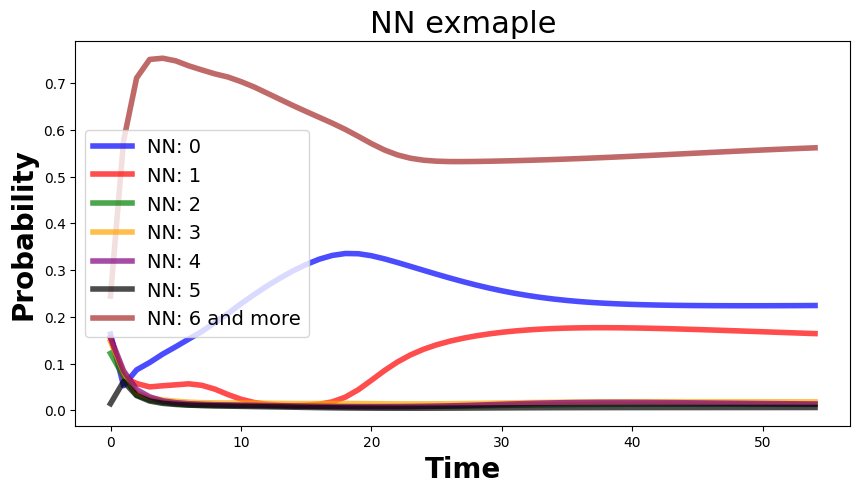

In [9]:
ind_0 = 0
with torch.no_grad():
    plt.figure(figsize = (10,5))
    plt.plot(torch.arange(sueqence_len), soft[ind_0,:,0:1].sum(dim =1).cpu(), label = 'NN: 0', linewidth=4, color = 'blue', alpha = 0.7)
    plt.plot(torch.arange(sueqence_len), soft[ind_0,:,1:2].sum(dim =1).cpu(), label = 'NN: 1', linewidth=4, color = 'red', alpha = 0.7)
    plt.plot(torch.arange(sueqence_len), soft[ind_0,:,2:3].sum(dim =1).cpu(), label = 'NN: 2', linewidth=4, color = 'green', alpha = 0.7)
    plt.plot(torch.arange(sueqence_len), soft[ind_0,:,3:4].sum(dim =1).cpu(), label = 'NN: 3', linewidth=4, color = 'orange', alpha = 0.7)
    plt.plot(torch.arange(sueqence_len), soft[ind_0,:,4:5].sum(dim =1).cpu(), label = 'NN: 4', linewidth=4, color = 'purple', alpha = 0.7)  
    plt.plot(torch.arange(sueqence_len), soft[ind_0,:,5:6].sum(dim =1).cpu(), label = 'NN: 5', linewidth=4, color = 'black', alpha = 0.7)  
    plt.plot(torch.arange(sueqence_len), soft[ind_0,:,6:].sum(dim =1).cpu(), label = 'NN: 6 and more', linewidth=4, color = 'brown', alpha = 0.7)  

    
    plt.title('NN exmaple', fontsize= 22)
    plt.legend(fontsize= 14)
    plt.xlabel('Time', fontsize = 20, fontweight ='bold')
    plt.ylabel('Probability', fontsize = 20, fontweight ='bold')
    plt.show() 